# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("scale(area)*scale(income) + home_value")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


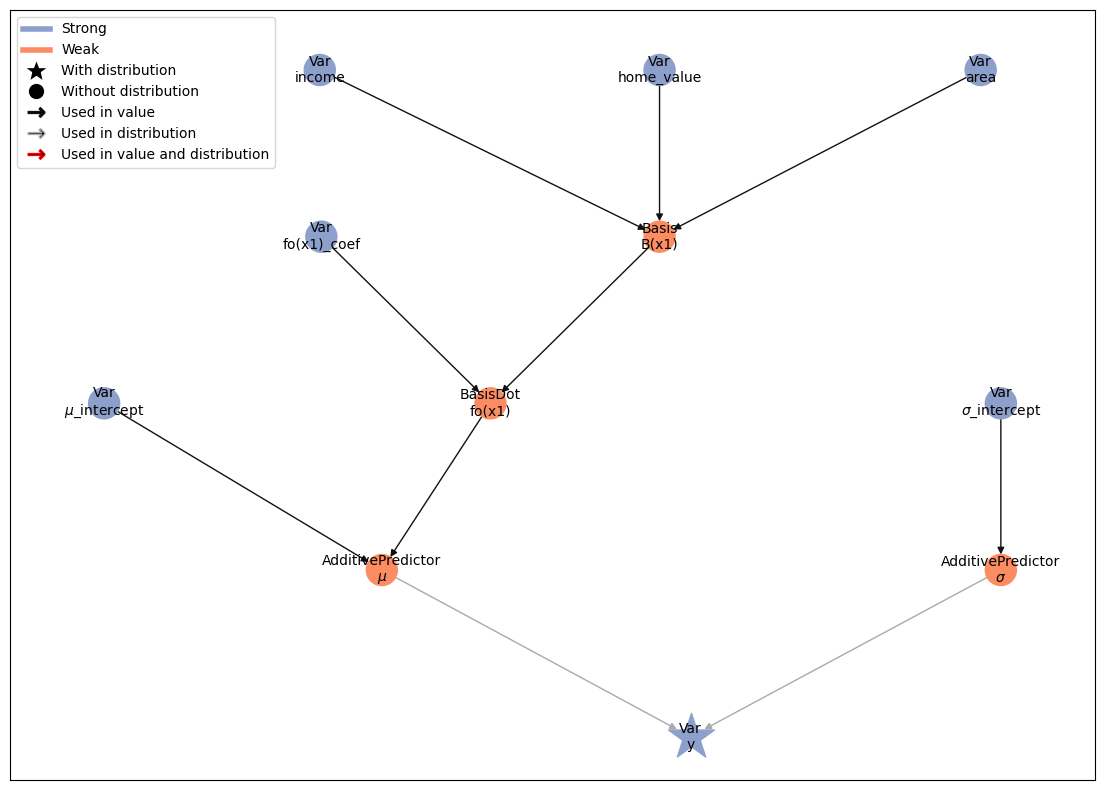

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=4000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', 'fo(x1)_coef'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  7.94chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1157.05chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 0, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1733.18chunk/s]
liesel.g

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel       mean        sd     q_0.05  \
parameter          index                                              
$\mu$_intercept    ()     kernel_01  45.565804  4.329293  38.390575   
$\sigma$_intercept ()     kernel_00   2.442598  0.107916   2.270419   
fo(x1)_coef        (0,)   kernel_02  -1.276699  1.928730  -4.513089   
                   (1,)   kernel_02  -9.316213  2.216660 -13.075607   
                   (2,)   kernel_02  -0.293289  0.105446  -0.468210   
                   (3,)   kernel_02   2.104978  1.811619  -0.901468   

                              q_0.5     q_0.95  sample_size     ess_bulk  \
parameter          index                                                   
$\mu$_intercept    ()     45.549774  52.689362         4000  1149.798719   
$\sigma$_intercept ()      2.440184   2.622992         4000  3373.521950   
fo(x1)_coef        (0,)   -1.310735   1.948272         4000  4137.911761   
                   (1,)   -9.303255  -5.722794         4000  2904.238596   
                   (2,)   -0.293899  -0.121816         4000  1069.806853   
                   (3,)    2.125941   5.070340         4000  3812.363045   

                             ess_tail      rhat  
parameter          index                         
$\mu$_intercept    ()     1993.423474  0.999995  
$\sigma$_intercept ()     3612.787285  0.999679  
fo(x1)_coef        (0,)   4143.684841  1.000905  
                   (1,)   3539.979812  1.001010  
                   (2,)   1978.355820  1.000752  
                   (3,)   4055.402664  1.000689  

Error summary:

                                                   count  relative
kernel    error_code error_msg           phase                    
kernel_00 90         nan acceptance prob warmup        2  0.000125
                                         posterior     0       0.0

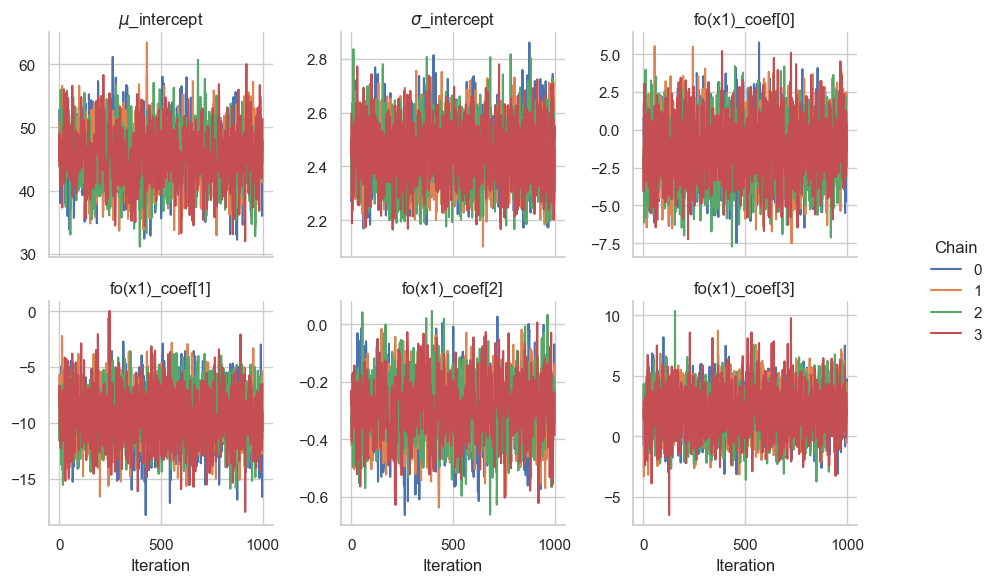

In [10]:
gs.plot_trace(results)